In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import datetime

### file hierarchy and database connection vars

In [2]:
# directory & file hierarchy
iterationName = 'cdm_run_v3'
exp_path = 'museumstation'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']


### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [4]:
# wave 1 of data collection (16 classes)
experiment_name = 'cdm_run_v3'
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
image_recs_all = coll.find({'$and': [{'dataType':'finalImage'}]})
numImages = image_recs_all.count()
lastImage = image_recs_all[numImages - 1]
lastestDate = lastImage['date']

print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), iterationName)
print 'We currently have {} total drawings from {}.'.format(numImages, iterationName)
print 'The last drawing was made at {}.'.format(lastestDate)

We currently have 2960 valid sessions from cdm_run_v3.
We currently have 15994 total drawings from cdm_run_v3.
The last drawing was made at 2018-08-01T23:33:48.404Z.


### How many of these drawings are from kids and not on practice trials?

In [5]:
image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}}]})
print 'We currently have {} raw images from kids in {}.'.format(image_recs_kids.count(), iterationName)


We currently have 14331 raw images from kids in cdm_run_v3.


In [6]:
image_recs_kids_not_practice = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':{"$nin": ['square','this circle','shape']}}]})
print 'We currently have {} non-practice trials from kids in {}.'.format(image_recs_kids_not_practice.count(), iterationName)

We currently have 8157 non-practice trials from kids in cdm_run_v3.


### Get out number of drawings per age and class

In [13]:
ages = {'age2','age3','age4','age5','age6','age7','age8','age9','age10'}
# categories_run1 = {
# 'a boat',
# 'a car',
# 'a cup',
# 'a dog',
# 'a fish',
# 'a house',
# 'a person',
# 'a tree'}

# categories_run2 = {'an airplane',
# 'a bike',
# 'a bird',
# 'a bowl',
# 'a chair',
# 'a couch',
# 'a phone',
# 'a rabbit'}


categories = {
'an airplane',
'a bike',
'a bird',
'a bowl',
'a chair',
'a couch',
'a phone',
'a rabbit',
'a boat',
'a car',
'a cup',
'a dog',
'a fish',
'a house',
'a person',
'a tree'}


In [14]:
## Counts by age and clas
counts=[]
category=[]
age=[]

for thiscat in categories:
    for thisage in ages:
        thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':thisage},{'category':thiscat}]})
#         print 'We have {} drawings for {} and {} '.format(thissubset.count(),thisage, thiscat)
        counts.append(thissubset.count())
        category.append(thiscat)
        age.append(thisage)

In [10]:
# Counts by class only
cat_counts=[]
for thiscat in categories:
    thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':thiscat}]})
    cat_counts.append(thissubset.count())

In [15]:
C = pd.DataFrame([counts,category,age])
C = C.transpose()
C.columns = ['counts','category','age']

In [12]:
cat_counts

[313, 330, 331, 326, 324, 336, 338, 319]

### Make some basic plots

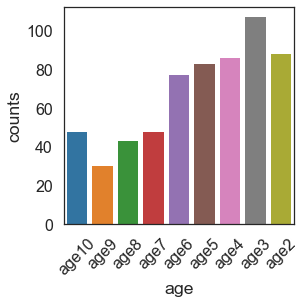

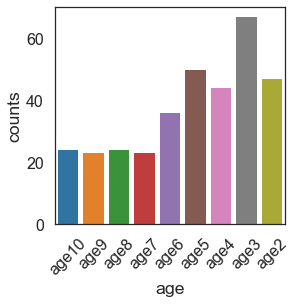

In [16]:
# df.loc[df['column_name'] == some_value]
bike = C.loc[C['category']=="a bowl"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=bike,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)
    
    
couch = C.loc[C['category']=="a person"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=couch,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)

In [46]:


# plt.figure(figsize=(14,4))
# plt.subplot(1,3,1)
# sns.barplot(data=C,x='age',y='counts')
# # set_xticklabels(rotation=30)

# plt.figure(figsize=(14,4))
# plt.subplot(1,3,1)
# sns.barplot(data=C,x='category',y='counts')


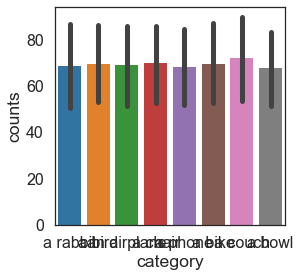

In [47]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.barplot(data=C,x='category',y='counts')


In [19]:
if really_run_this:
    imsize = 224 ## img writing size, optimized for CNN
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:                                                            
            category_dir = os.path.join(sketch_dir,imrec['category'])
            if not os.path.exists(category_dir):
                os.makedirs(category_dir)
            fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
            if os.path.isfile(fname):
                ## skip this image!
                print('skipping image')
            else:
                stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                  {'sessionId':s}, 
                                  {'dataType':'stroke'},
                                  {'trialNum': imrec['trialNum']}]}).sort('time')   
                if stroke_recs.count() > 0 and imrec['age']!='adult':
                    imgData = imrec['imgData'];
                    with open(fname, "wb") as fh:
                        fh.write(imgData.decode('base64'))                        

skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping image
skipping i

KeyboardInterrupt: 

0

In [18]:
really_run_this = 1
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    age = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    submit_date_readable = []
    draw_duration = []
    filename = []
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:                                                            
                stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                  {'sessionId':s}, 
                                                  {'dataType':'stroke'},
                                                  {'trialNum': imrec['trialNum']}]}).sort('time')   

                if 'age' in imrec.keys():
                    if imrec['age'] != 'adult':
                        
                        os.path.isfile(path)
                        
                        if stroke_recs.count() > 0: ## only include trials if the drawings are not blank   
                            
                           
                            
                            session_id.append(imrec['sessionId'])        
                            trial_num.append(imrec['trialNum']) 
                            category.append(imrec['category'])
                            age.append(imrec['age'])
                            
                            png.append(imrec['imgData'])
                            submit_time.append(imrec['time'])
                            readadble_date = datetime.datetime.fromtimestamp(imrec['time']/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
                            submit_date_readable.append(readadble_date)
                        
                            submit_date.append(imrec['date'])
                            filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId'])))
                            num_strokes.append(stroke_recs.count())
                            _svg = [] # this keeps track of the strokes from THIS final image
                            _svg_times = []
                            for strec in stroke_recs:
                                _svg.append(strec['svg'])
                                _svg_times.append(strec['time'])
                            draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                            svg.append(_svg)
                            svg_times.append(_svg_times)

                            ## and write out image data here too
                            imgData = imrec['imgData'];
                            filestr = base64.b64decode(imgData)
                            category_dir = os.path.join(sketch_dir,imrec['category'])
                            if not os.path.exists(category_dir):
                                os.makedirs(category_dir)
                            fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
                            with open(fname, "wb") as fh:
                                fh.write(imgData.decode('base64'))  
                        

AutoReconnect: connection closed

In [61]:
really_run_this = 1
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    age = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    submit_date_readable = []
    draw_duration = []
    filename = []
    
    for cat in ['a boat','a car','a cup','a dog','a fish','a house','a person','a tree']:
        imgcount = 0
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'category':cat},{'dataType':'finalImage'}]}).sort('time')   
        for imrec in image_recs:  
                if imgcount < 100:
                    stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                      {'sessionId':imrec['sessionId']}, 
                                                      {'dataType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')   

                    if 'age' in imrec.keys():
                        if imrec['age'] != 'adult':
                            if stroke_recs.count() > 0: ## only include trials if the drawings are not blank    
                                imgcount += 1
                                session_id.append(imrec['sessionId'])        
                                trial_num.append(imrec['trialNum']) 
                                category.append(imrec['category'])
                                age.append(imrec['age'])

                                png.append(imrec['imgData'])
                                submit_time.append(imrec['time'])
                                readadble_date = datetime.datetime.fromtimestamp(imrec['time']/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
                                submit_date_readable.append(readadble_date)

                                submit_date.append(imrec['date'])
                                filename.append(os.path.join(sketch_dir,'{}_{}.png'.format(imrec['category'], imgcount)))
                                num_strokes.append(stroke_recs.count())
                                _svg = [] # this keeps track of the strokes from THIS final image
                                _svg_times = []
                                for strec in stroke_recs:
                                    _svg.append(strec['svg'])
                                    _svg_times.append(strec['time'])
                                draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                                svg.append(_svg)
                                svg_times.append(_svg_times)

                                ## and write out image data here too
                                imgData = imrec['imgData'];
                                filestr = base64.b64decode(imgData)
                                category_dir = os.path.join(sketch_dir,imrec['category'])
                                if not os.path.exists(category_dir):
                                    os.makedirs(category_dir)
                                fname = os.path.join(category_dir,'{}_{}.png'.format(imrec['category'],imgcount))
                                with open(fname, "wb") as fh:
                                    fh.write(imgData.decode('base64'))  


In [ ]:
submit_date_readable[-100]

In [62]:
if really_run_this:
    X = pd.DataFrame([category,age,num_strokes,filename])
    X = X.transpose()
    X.columns = ['category','age','num_strokes', 'filename']
    X.to_csv("scribble_annotate.csv")

In [ ]:
if really_run_this:
    X_out = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,draw_duration,filename])
    X_out = X_out.transpose()
    X_out.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','draw_duration', 'filename']

    X_out.to_csv('May31th_usage.csv')

In [ ]:
# def get_bounding_box(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# merged_experiment_name = 'E1cd'

# if really_run_this:

#     ## add mean pixel intensity (amount of ink spilled) & bounding box coords 
#     mean_intensity = []
#     bounding_box = []
#     imsize = 100
#     numpix = imsize**2
#     thresh = 250
#     for i,_d in X.iterrows():
#         imgData = _d['png']
#         filestr = base64.b64decode(imgData)
#         fname = os.path.join('sketch.png')
#         with open(fname, "wb") as fh:
#             fh.write(imgData.decode('base64'))
#         im = Image.open(fname).resize((imsize,imsize))
#         _im = np.array(im)
#         mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
#         # bounding box part
#         rmin, rmax, cmin, cmax = get_bounding_box(np.array(Image.open(fname)))
#         bounding_box.append(tuple((rmin, rmax, cmin, cmax)))

#     ## add to dataframe    
#     X = X.assign(mean_intensity=pd.Series(mean_intensity).values)
#     X = X.assign(bounding_box=pd.Series(bounding_box).values)
    
#     # save out csv
#     if not os.path.exists('../preprocessed_data'):
#         os.makedirs('../preprocessed_data')
#     X.to_csv('../preprocessed_data/museumdraw_{}_data.csv'.format(merged_experiment_name))


### load drawing metadata csv back in

In [ ]:
plt.hist(X.age,normed=False)
plt.xticks(rotation=90)
len(X.age)
sum(X.age != 'adult')

### Basic visualizations

In [ ]:
np.sum(X.draw_duration.values>25)

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [ ]:
X.category

In [ ]:
unique = X.drop_duplicates(["session_id"])
unique.count()
# sum(unique.age != 'adult')
sum(unique.age != 'adult')

In [ ]:
X.

In [ ]:
unique

In [ ]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat